# Step 1:  Light curve simulation
# Step 2: Fitting the simuated light curve (Below)

## Setup

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle, SkyOffsetFrame
from astropy.time import Time
from regions import CircleSkyRegion

import logging

log = logging.getLogger(__name__)

And some gammapy specific imports

In [27]:
from gammapy.data import Observation
from gammapy.irf import load_cta_irfs
from gammapy.datasets import SpectrumDataset, Datasets
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ExpDecayTemporalModel,
    PointSpatialModel,
    SkyModel,
    Models,
)
from gammapy.maps import MapAxis
from gammapy.estimators import LightCurveEstimator
from gammapy.makers import SpectrumDatasetMaker
from gammapy.modeling import Fit
from gammapy.modeling.models import LightCurveTemplateTemporalModel
from scipy.optimize import curve_fit

## Simulating a light curve

We will simulate 10 datasets using an `PowerLawSpectralModel` and a `ExpDecayTemporalModel`. The important thing to note here is how to attach a different `GTI` to each dataset.

In [28]:
# Loading IRFs
irfs = load_cta_irfs("/Users/sonal/PostDocWork/SummerStudent_Helena/Prod5-North-20deg-AverageAz-4LSTs09MSTs.18000s-v0.1.fits")
#irfs = load_cta_irfs('/Users/sonal/PostDocWork/gammapy-tutorials/datasets/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits')

In [29]:
# Reconstructed and true energy axis

#center = SkyCoord(0.0, 0.0, unit="deg", frame="galactic")
center = SkyCoord(135.67, 01.086, unit="deg", frame="galactic")  #LS I +61° 303

energy_axis = MapAxis.from_edges(
    np.logspace(-0.5, 1.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.2, 2.0, 31), unit="TeV", name="energy_true", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=center, radius=on_region_radius)

In [30]:
# Pointing position
pointing = SkyCoord(135.67+0.5, 01.086+0.5, unit="deg", frame="galactic")


Note that observations are usually conducted in  Wobble mode, in which the source is not in the center of the camera. This allows to have a symmetrical sky position from which background can be estimated.

In [31]:
# Define the source model: A combination of spectral and temporal model


gti_t0 = Time("2021-01-01") 
spectral_model = PowerLawSpectralModel(
    index=3, amplitude="1e-11 cm-2 s-1 TeV-1", reference="1 TeV"
)


temporal_model = LightCurveTemplateTemporalModel.read('TemporalProfile_Sinusoidal_Period30d.fits')

model_simu = SkyModel(
    spectral_model=spectral_model,
    temporal_model=temporal_model,
    name="model-simu",
)

print(temporal_model)

LightCurveTemplateTemporalModel model summary:
Start time: 59215.0 MJD
End time: 59364.69696969697 MJD
Norm min: 6.293616306246586e-05
Norm max: 0.9999370638369376



In [32]:
# Look at the model
model_simu.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,int64
index,3.0000e+00,,nan,nan,False,0.000e+00
amplitude,1.0000e-11,cm-2 s-1 TeV-1,nan,nan,False,0.000e+00
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00


Now, define the start and observation livetime wrt to the reference time, `gti_t0`

In [33]:
n_obs = 30

tstart = np.linspace(0,60,30) * u.d
lvtm = np.zeros(n_obs)
lvtm.fill(60)
lvtm = lvtm * u.min
print(tstart, lvtm)

[ 0.          2.06896552  4.13793103  6.20689655  8.27586207 10.34482759
 12.4137931  14.48275862 16.55172414 18.62068966 20.68965517 22.75862069
 24.82758621 26.89655172 28.96551724 31.03448276 33.10344828 35.17241379
 37.24137931 39.31034483 41.37931034 43.44827586 45.51724138 47.5862069
 49.65517241 51.72413793 53.79310345 55.86206897 57.93103448 60.        ] d [60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60.
 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60.] min


Now perform the simulations

In [34]:
datasets = Datasets()


empty = SpectrumDataset.create(
    e_reco=energy_axis, e_true=energy_axis_true, region=on_region, name="empty"
)

maker = SpectrumDatasetMaker(selection=["exposure", "background", "edisp"])

for i in range(n_obs):
    obs = Observation.create(
        pointing=pointing,
        livetime=lvtm[i],
        tstart=tstart[i],
        irfs=irfs,
        reference_time=gti_t0,
        obs_id=i,
    )
    #print(obs)
    empty_i = empty.copy(name=f"dataset_{i}")
    #maker = SpectrumDatasetMaker(selection=["aeff", "background", "edisp"])
    dataset = maker.run(empty_i, obs)
    dataset.models = model_simu
    dataset.fake()
    datasets.append(dataset)

The reduced datasets have been successfully simulated. Let's take a quick look into our datasets.

In [35]:
datasets.info_table()

name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,
str10,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str4,float64
dataset_0,321,18.341005418072154,302.65899458192786,35.10384295247295,353.92934755297483,18.341005418072154,335.5883421349027,342326351.5317853,3391149743.6206517,3600.0000000000005,3600.0000000000005,0.08916666666666666,0.0050947237272422645,0.0840719429394244,9,9,cash,-2109.744992716811
dataset_1,507,18.341005418072005,488.65899458192797,48.87253760642897,494.03877302062284,18.341005418072005,475.6977676025508,342326351.5317825,3391149743.6206236,3599.999999999971,3599.999999999971,0.14083333333333448,0.0050947237272422645,0.1357386096060922,9,9,cash,-3706.701226994862
dataset_2,596,18.34100541807215,577.6589945819278,54.71887111972635,607.9123476346858,18.34100541807215,589.5713422166135,342326351.53178525,3391149743.6206512,3600.0,3600.0,0.16555555555555557,0.005094723727242264,0.16046083182831328,9,9,cash,-4627.659301034417
dataset_3,629,18.34100541807215,610.6589945819278,56.7952630903637,674.5566413599513,18.34100541807215,656.2156359418792,342326351.53178525,3391149743.6206512,3600.0,3600.0,0.17472222222222222,0.005094723727242264,0.16962749849497993,9,9,cash,-4876.478851998151
dataset_4,701,18.341005418071557,682.6589945819285,61.17748596468144,681.6866569416806,18.341005418071557,663.3456515236089,342326351.5317742,3391149743.6205416,3599.9999999998836,3599.9999999998836,0.1947222222222285,0.005094723727242264,0.18962749849498628,9,9,cash,-5624.503332711122
dataset_5,678,18.34100541807215,659.6589945819278,59.79843527180916,627.9839933738155,18.34100541807215,609.6429879557433,342326351.53178525,3391149743.6206512,3600.0,3600.0,0.18833333333333332,0.005094723727242264,0.18323860960609106,9,9,cash,-5393.906118863865
dataset_6,537,18.34100541807215,518.6589945819278,50.88642619373339,523.337474545119,18.34100541807215,504.9964691270468,342326351.53178525,3391149743.6206512,3600.0,3600.0,0.14916666666666667,0.005094723727242264,0.14407194293942438,9,9,cash,-4037.7107668462527
dataset_7,374,18.34100541807215,355.65899458192786,39.293627487069365,387.02201587404903,18.34100541807215,368.68101045597695,342326351.53178525,3391149743.6206512,3600.0,3600.0,0.10388888888888889,0.005094723727242264,0.09879416516164663,9,9,cash,-2532.4725177654122


In [36]:
#datasets.info_table().keys()

Text(0, 0.5, 'Excess counts')

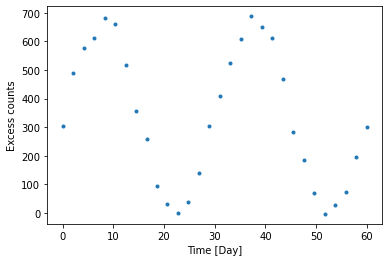

In [37]:
data_table = datasets.info_table()
y_data_simu=data_table['excess']
plt.plot(tstart, y_data_simu,'.')
plt.xlabel('Time [Day]')
plt.ylabel('Excess counts')

## Step 2: Fitting the light curve

In [38]:
#Define the function that we want to fit (Sinusoidal in our case)

def my_sin(t, freq, amplitude, phase, offset):
    return np.sin(t * freq + phase) * amplitude + offset

(array([ 2.09451807e-01,  3.35161312e+02, -3.18264836e-02,  3.38610971e+02]), array([[ 8.45642936e-07,  6.32344667e-04, -2.52619947e-05,
         3.99468866e-05],
       [ 6.32344667e-04,  3.56055872e+01, -1.86838389e-02,
         6.44534820e-02],
       [-2.52619947e-05, -1.86838389e-02,  1.04787141e-03,
        -4.47272877e-03],
       [ 3.99468866e-05,  6.44534820e-02, -4.47272877e-03,
         1.70195556e+01]]))


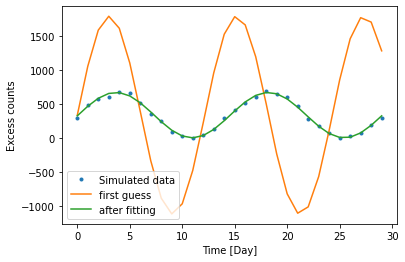

In [39]:
t = np.linspace(0,60,30)


g_freq = 0.25
g_amplitude = 3*np.max(y_data_simu)/(2**0.5) 
g_phase = 0
g_offset = np.mean(y_data_simu)
p0=[g_freq, g_amplitude, g_phase, g_offset]


#Do the fitting
fit = curve_fit(my_sin, t, y_data_simu, p0=p0)
print(fit)

#This is the model with our guess parameters, to see how the function with initial paramaters looks
y_guess = my_sin(t, *p0)

# recreate the fitted curve using the optimized parameters
y_fit = my_sin(t, *fit[0])

plt.plot(y_data_simu, '.', label='Simulated data')
plt.plot(y_guess, label='first guess')
plt.plot(y_fit, label='after fitting')

plt.legend(loc='lower left')
plt.xlabel('Time [Day]')
plt.ylabel('Excess counts')
plt.show()